# MATRIX FACTORIZATION WITH STOCHASTIC GRADIENT DESCENT FOR RECOMMENDER SYSTEMS


In [3]:
# Imports
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_dataset(root_path):
    print('loading..')
    df_train = pd.read_csv(os.path.join(root_path,'X_train.csv'))
    df_test  = pd.read_csv(os.path.join(root_path,'X_test.csv'))
    print('loading done.')
    X_train , X_test = df_train.to_numpy(),df_test.to_numpy()
    return X_train,X_test

X_train,X_test = load_dataset('/content/drive/MyDrive/Colab Notebooks/db')
print(f'{X_train.shape} train sample , {X_test.shape} test sample' )

loading..
loading done.
(95794, 3) train sample , (5042, 3) test sample


In [4]:
def ratings_tuples_2_matrix(samples):
    row , col , data = samples[:,1] , samples[:,0] , samples[:,2]
    row = row.astype(np.int64)
    col = col.astype(np.int64)
    m , n = int(np.max(row)) , int(np.max(col))
    R = sps.csc_matrix((data,(row,col)))
    return R
  


In [13]:


class SGDMF:
  '''
    @:param
    m : number of items (movies)
    n : number of users
    R : Ratings Matrix of size (m x n)
    K : number of recommendations t be returned
    alpha : Learning rate for I
    beta : Learning rate for U
    lmda : Regularization constant for I
    mu  : Regularization constant for U
    nb_steps : # of epochs to train the model
    test_size : The Testing set length
  '''
  def __init__(self,X_train,alpha=0.003,beta=0.003,lmda=0.006,mu=0.006,K=1,nb_steps=20,bias=False,verbose=1):
      self.X_train = X_train
      self.m , self.n = int(max(max(X_train[:,1]),max(X_test[:,1]))) , int(max(max(X_train[:,0]),max(X_test[:,0])))
      self.K = K
      rvs = stats.norm(loc=0, scale=1/K).rvs
      self.I = sps.random(self.m, K, density=0.8, data_rvs=rvs).toarray()
      self.U = sps.random(self.n, K, density=0.8, data_rvs=rvs).toarray()
      self.alpha , self.beta = alpha, beta
      self.lmda , self.mu = lmda, mu
      self.nb_steps = nb_steps
      self.bias = bias
      self.verbose = verbose
      # Init biases
      if bias :
          self.b_i = np.zeros(self.m)
          self.b_u = np.zeros(self.n)
          self.b = np.random.rand(self.m, self.n)


  def predicted_rating_mx(self):
      I,UT = sps.csc_matrix(self.I),sps.csc_matrix(self.U.T)
      result = sps.csc_matrix(I.dot(UT))
      if self.bias: 
         result += self.b + self.b_i[:,np.newaxis] + self.b_u[np.newaxis,:]  
      return result

  def rmse(self,samples):
      R = ratings_tuples_2_matrix(samples)
      xs, ys = R.nonzero()
      predicted = self.predicted_rating_mx()
      err = np.sqrt(np.mean([(R[x,y]-predicted[x-1,y-1])**2 for x,y in zip(xs,ys)]))
      return err


  # TODO add bias
  def predict_rating(self, i, u):
      result = self.I[i, :].dot(self.U[u, :].T)
      if self.bias :
        result += self.b[i,u] + self.b_i[i] + self.b_u[u]
      return  result
      
  
  '''
    sgd : Stochastic Gradient Descent Algorithm to learn on
            X_train and test its performance on X_test
  '''
  def sgd(self):
     for u,i,r in self.X_train:
        u, i = int(u)-1 , int(i)-1
        r_pred = self.predict_rating(i,u)
        err = r - r_pred

        if self.bias : 
          # Update biases
          self.b_i[i] += self.alpha * (err - self.lmda * self.b_i[i])
          self.b_u[u] += self.beta * (err - self.mu * self.b_u[u])

        # Items and Users vectors update by gradient pass
        self.I[i,:] += 2*self.alpha* (err * self.U[u,:] - 2 * self.lmda * self.I[i,:])
        self.U[u, :] += 2*self.beta* (err * self.I[i,:] - 2 * self.mu * self.U[u,:])    

  def get_ratings(self):
    return ratings_tuples_2_matrix(self.X_train)

  def train(self,cost = 'rmse', validation_split = None):

    print('Training the SGDMF...')
    
    if validation_split : 
      p = np.array([1-validation_split,validation_split])
      self.X_train , self.X_val = np.split(self.X_train,(len(self.X_train)*p[:-1].cumsum()).astype(int))
    
    history = {}
    losses , exe_time, val_losses = [],[],[]
    i = 0
    while (i < self.nb_steps):
        start = time.time()
        np.random.shuffle(self.X_train)
        self.sgd()
        loss = getattr(self, cost)(self.X_train)
        val_loss = getattr(self, cost)(self.X_val)
        losses.append(loss)
        val_losses.append(val_loss)
        end = time.time()
        exe_time.append(end-start)
        if self.verbose :
          print(f'Epoch [{i+1}] --- loss : {loss} , val_loss : {val_loss} , ellapsed time : {end-start}')
        i += 1

    history['train_loss'] = losses
    history['val_loss'] = val_losses
    history['exe_time'] = exe_time

    return history



In [26]:
sgdmf = SGDMF(X_train=X_train,K = 1 ,nb_steps=20)
ratings=sgdmf.get_ratings()
ratings=ratings.toarray()

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings


dimension:  (193610, 611)
sparsity: 0.1%


array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 4. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Training-validation loss with {RMSE} for SGDMF With biases

In [6]:
#  SGDMF With biases  k = 1
sgdmf_bias = SGDMF(X_train=X_train,K = 1 ,nb_steps=20,bias=True)
history_bias = sgdmf_bias.train(validation_split=0.1)

Training the SGDMF...
Epoch [1] --- loss : 1.7141969714515888 , val_loss : 1.713789891928055 , ellapsed time : 11.178777933120728
Epoch [2] --- loss : 1.3646919525752474 , val_loss : 1.3733234022817973 , ellapsed time : 10.834696769714355
Epoch [3] --- loss : 1.2184231180040221 , val_loss : 1.2325412080628593 , ellapsed time : 10.654950380325317
Epoch [4] --- loss : 1.1388829707887194 , val_loss : 1.158142705507818 , ellapsed time : 10.844245910644531
Epoch [5] --- loss : 1.0881902835246942 , val_loss : 1.1106992445839154 , ellapsed time : 11.331815958023071
Epoch [6] --- loss : 1.0524290527875815 , val_loss : 1.0777598658518786 , ellapsed time : 10.743684530258179
Epoch [7] --- loss : 1.025499334968218 , val_loss : 1.0541790386417127 , ellapsed time : 10.08453893661499
Epoch [8] --- loss : 1.0042994541687427 , val_loss : 1.0347357709546017 , ellapsed time : 10.646520853042603
Epoch [9] --- loss : 0.9872747300569277 , val_loss : 1.0202666426259177 , ellapsed time : 10.109830379486084
E

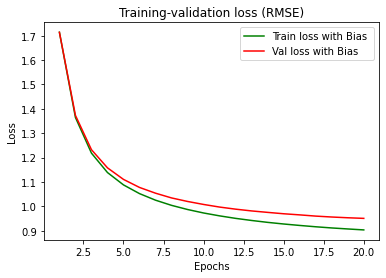

In [7]:
plt.style.use('seaborn-bright')
train_loss = history_bias['train_loss']
val_loss = history_bias['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Train loss with Bias ')
plt.plot(epochs, val_loss, 'r', label='Val loss with Bias')
plt.title('Training-validation loss (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Training-Val loss (RMSE) for SGDMF Without biases

In [15]:
#  SGDMF With No biases  k = 1
sgdmf_no_bias = SGDMF(X_train=X_train,K = 1 ,nb_steps=20)
history_no_bias = sgdmf_no_bias.train(validation_split=0.1)

Training the SGDMF...
Epoch [1] --- loss : 3.6510957196217673 , val_loss : 3.6706850998999387 , ellapsed time : 55.182289123535156
Epoch [2] --- loss : 3.492928483595879 , val_loss : 3.521414498930828 , ellapsed time : 54.15462374687195
Epoch [3] --- loss : 2.631332687648702 , val_loss : 2.672321817872514 , ellapsed time : 54.84899306297302
Epoch [4] --- loss : 2.0284657028393944 , val_loss : 2.1134835753500663 , ellapsed time : 55.595805168151855
Epoch [5] --- loss : 1.7220104290953164 , val_loss : 1.8453548452066029 , ellapsed time : 54.55306434631348
Epoch [6] --- loss : 1.5380065757138945 , val_loss : 1.6912999224904715 , ellapsed time : 54.62262153625488
Epoch [7] --- loss : 1.4128664731218417 , val_loss : 1.5907882149293782 , ellapsed time : 54.355156898498535
Epoch [8] --- loss : 1.3201874553845718 , val_loss : 1.518749837433094 , ellapsed time : 54.212329149246216
Epoch [9] --- loss : 1.2485768469228504 , val_loss : 1.4669113207184947 , ellapsed time : 54.989920139312744
Epoch 

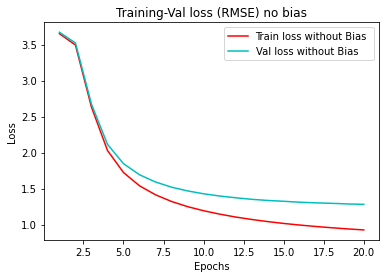

In [16]:
train_loss_no_bias = history_no_bias['train_loss']
val_loss_no_bias = history_no_bias['val_loss']


epochs = range(1, len(train_loss_no_bias) + 1)


plt.plot(epochs, train_loss_no_bias, 'r', label='Train loss without Bias ')
plt.plot(epochs, val_loss_no_bias, 'c', label='Val loss without Bias')
#plt.plot(tst_size, tst_loss_no_bias, 'm', label='Test loss with No Bias')
plt.title('Training-Val loss (RMSE) no bias')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Validation loss {RMSE} bias vs no bias

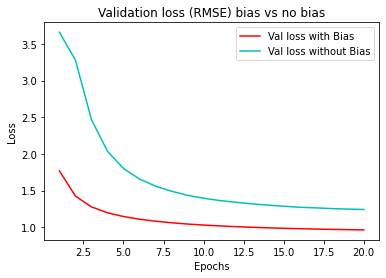

In [ ]:
plt.plot(epochs, val_loss, 'r', label='Val loss with Bias ')
plt.plot(epochs, val_loss_no_bias, 'c', label='Val loss without Bias')
#plt.plot(tst_size, tst_loss_no_bias, 'm', label='Test loss with No Bias')
plt.title('Validation loss (RMSE) bias vs no bias')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Training loss (RMSE) with different k

In [ ]:
list_k=[1,2,3,5,10,12,15,20,30]
list_history = []

for lk in list_k:
     # SGDMF With biases 
     sgdmf_bias = SGDMF(X_train=X_train,K = lk ,nb_steps=100,bias=True)
     history_bias = sgdmf_bias.train()
     list_history.append(history_bias)


Training the SGDMF...
Epoch [1] , loss : 1.650842399857541 , ellapsed time : 9.73947024345398
Epoch [2] , loss : 1.3209245920024841 , ellapsed time : 8.17403507232666
Epoch [3] , loss : 1.185961772026143 , ellapsed time : 8.580536842346191
Epoch [4] , loss : 1.1127074378331758 , ellapsed time : 8.520039558410645
Epoch [5] , loss : 1.0656087799475205 , ellapsed time : 8.315293788909912
Epoch [6] , loss : 1.0321844537322453 , ellapsed time : 8.368211507797241
Epoch [7] , loss : 1.0070042228089613 , ellapsed time : 8.363779544830322
Epoch [8] , loss : 0.9871783619612164 , ellapsed time : 8.067321062088013
Epoch [9] , loss : 0.9712351480928314 , ellapsed time : 8.187162160873413
Epoch [10] , loss : 0.9581253138365611 , ellapsed time : 8.444019794464111
Epoch [11] , loss : 0.9469935993711768 , ellapsed time : 8.466764450073242
Epoch [12] , loss : 0.9375712477870347 , ellapsed time : 8.434634685516357
Epoch [13] , loss : 0.9295754670494142 , ellapsed time : 8.419657707214355
Epoch [14] , los

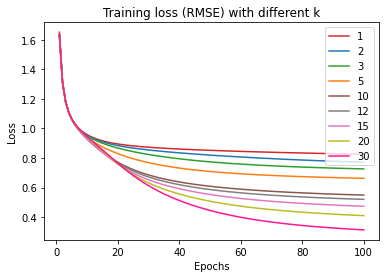

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 101)
#all_colors = list(plt.cm.colors.cnames.keys())
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 'firebrick', 'mediumseagreen']      

index = 0

for k in list_k:
  plt.plot(epochs, list_history[index]['train_loss'], mycolors[index], label=str(k))
  index+=1



plt.title('Training loss (RMSE) with different k')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Alternating Least Squares for Recommendation Systems

In [8]:
def load_dataset_als(root_path):
    print('loading..')
    df_train = pd.read_csv(os.path.join(root_path,'X_train.csv'))
    df_test  = pd.read_csv(os.path.join(root_path,'X_test.csv'))
    print('loading done.')
    X_train , X_test = df_train.to_numpy(),df_test.to_numpy()
    return X_train,X_test

In [9]:
import warnings
warnings.filterwarnings('ignore')

class ALSMF:
  def __init__(self,X_train,K=1,lmda=0.002,mu=0.002,nb_steps=20,verbose=True):
      self.X_train = X_train
      self.R = ratings_tuples_2_matrix(X_train)
      self.m, self.n = int(max(max(X_train[:,1]),max(X_test[:,1]))) , int(max(max(X_train[:,0]),max(X_test[:,0])))
      self.K = K
      rvs = stats.norm(loc=0, scale=1/K).rvs
      self.I = sps.random(self.m+1, K, density=0.8, data_rvs=rvs).toarray()
      self.U = sps.random(self.n+1, K, density=0.8, data_rvs=rvs).toarray()
      self.lmda = lmda
      self.mu = mu
      self.nb_steps = nb_steps
      self._v = verbose

  def rmse(self,samples):
    R = ratings_tuples_2_matrix(samples)
    xs, ys = R.nonzero()
    predicted = self.predicted_rating_mx()
    err = np.sqrt(np.mean([(R[x,y]-predicted[x-1,y-1])**2 for x,y in zip(xs,ys)]))
    return err

  def als_step(self,variable_vecs,fixed_vecs,reg_val,turn='u'):
        if fixed_vecs.shape[1] > fixed_vecs.shape[0] :
          fixed_vecs = fixed_vecs.T
        variable_vecs,fixed_vecs = sps.csc_matrix(variable_vecs),sps.csc_matrix(fixed_vecs)
        
        if turn == 'i' :
            UTU = fixed_vecs.T.dot(fixed_vecs)
            lmda_I = sps.eye(UTU.shape[0]) * reg_val
            INV = sps.csc_matrix(UTU + lmda_I)
            RU = sps.csc_matrix(self.R.dot(fixed_vecs))

            variable_vecs = sps.linalg.spsolve(INV, RU.T)

        elif turn == 'u' :
            ITI = fixed_vecs.T.dot(fixed_vecs)
            mu_I = sps.eye(ITI.shape[0]) * reg_val
            RTI = sps.csc_matrix(self.R.T.dot(fixed_vecs))
            INV = sps.csc_matrix(ITI + mu_I)

            variable_vecs = sps.linalg.spsolve(INV, RTI.T)
        return variable_vecs.toarray()
    
  def train(self,cost='rmse',validation_split = None):  

      print(f' Training ALSMF...')
      if validation_split : 
        p = np.array([1-validation_split,validation_split])
        self.X_train , self.X_val = np.split(self.X_train,(len(self.X_train)*p[:-1].cumsum()).astype(int))    
      
      history = {}
      losses ,  exe_time , val_losses = [],[],[]
      for i in range(self.nb_steps):
        start = time.time()
        self.I = self.als_step(self.I, self.U, self.lmda,turn='i')
        self.U = self.als_step(self.U, self.I, self.mu,turn='u')

        np.random.shuffle(self.X_train)
        pred = self.predicted_rating_mx()
        loss = getattr(self, cost)(self.X_train)
        val_loss = getattr(self, cost)(self.X_val)
        losses.append(loss)
        val_losses.append(val_loss)
        end = time.time()
        exe_time.append(end-start)
        if self._v:
          print(f'Epoch [{i+1}] --- loss : {loss} , val_loss : {val_loss} , ellapsed time : {end-start}')
      
      history['train_loss'] = losses
      history['val_loss'] = val_losses
      history['exe_time'] = exe_time

      return history

  def predicted_rating_mx(self):
    I,U = sps.csc_matrix(self.I),sps.csc_matrix(self.U)
    if I.shape[1] > I.shape[0] :
      I = I.T
    if U.shape[1] > U.shape[0] :
      U = U.T
    result = sps.csc_matrix(I.dot(U.T)) 
    return result


  def predict(self, i, u):
        return self.I[i, :].dot(self.U[u,:].T)


In [10]:
ALS_MF = ALSMF(X_train,K=1,lmda=0.006,mu=0.006,nb_steps = 20 ,verbose=True)
history_als = ALS_MF.train(validation_split=0.1)

 Training ALSMF...
Epoch [1] --- loss : 3.6440106074945295 , val_loss : 3.646567955320712 , ellapsed time : 57.27789354324341
Epoch [2] --- loss : 3.567780239375435 , val_loss : 3.569366758419903 , ellapsed time : 58.134092807769775
Epoch [3] --- loss : 3.5734162114091936 , val_loss : 3.5752556850320145 , ellapsed time : 59.17443585395813
Epoch [4] --- loss : 3.5748603038842304 , val_loss : 3.576727025207323 , ellapsed time : 57.925384283065796
Epoch [5] --- loss : 3.5751411714577803 , val_loss : 3.5770126775608055 , ellapsed time : 57.000754833221436
Epoch [6] --- loss : 3.575194320049142 , val_loss : 3.5770667452203164 , ellapsed time : 58.94099497795105
Epoch [7] --- loss : 3.5752043246474683 , val_loss : 3.5770769259008786 , ellapsed time : 57.89174747467041
Epoch [8] --- loss : 3.5752062011542196 , val_loss : 3.577078835920245 , ellapsed time : 57.35507893562317
Epoch [9] --- loss : 3.575206547750234 , val_loss : 3.5770791889209193 , ellapsed time : 57.33788228034973
Epoch [10] --

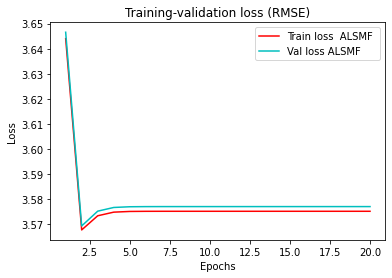

In [11]:
train_loss = history_als['train_loss']
val_loss = history_als['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.style.use('seaborn-bright')
plt.plot(epochs, train_loss, 'r', label='Train loss  ALSMF ')
plt.plot(epochs, val_loss, 'c', label='Val loss ALSMF')
plt.title('Training-validation loss (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# {SGD-MF} VS {ALS-MF} 

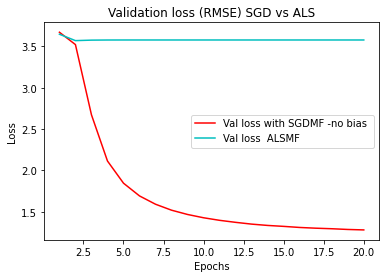

In [17]:
val_loss_no_bias = history_no_bias['val_loss']
val_loss_als = history_als['val_loss']
plt.plot(epochs, val_loss_no_bias, 'r', label='Val loss with SGDMF -no bias ')
plt.plot(epochs, val_loss_als, 'c', label='Val loss  ALSMF ')
plt.title('Validation loss (RMSE) SGD vs ALS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

